In [2]:
import pandas as pd

In [15]:
df = pd.read_csv('data/gdelt_news_articles.csv')

In [16]:
df.head()

,url,title,seendate,socialimage,domain,language,isquote,sentence,context
0,https://www.energy-pedia.com/news/united-kingd...,UK: Rendesco raises £6 million to replace gas ...,20240616T004638Z,NaN,energy-pedia.com,ENGLISH,0,This investment aligns with our commitment to ...,Rendesco's heat network solutions provide a co...
1,https://locusmag.com/2018/09/cory-doctorow-big...,Cory Doctorow: Big Tech: We Can Do Better Than...,20240616T004635Z,https://locusmag.com/wp-content/uploads/2017/0...,locusmag.com,ENGLISH,0,Tech policy is like climate change: every year...,I'm genuinely delighted that this moment has a...
2,https://www.abc.net.au/news/2024-06-15/act-why...,Why is Canberra so cold? And how might climate...,20240616T004634Z,https://live-production.wcms.abc-cdn.net.au/bf...,abc.net.au,ENGLISH,0,"Climate change likely to bring more hail, heat...",Canberra's higher elevation also means that ha...
3,http://www.la-regeneration.com/politique/2335-...,EU leadership takes office touting green ambition,20240616T004632Z,NaN,la-regeneration.com,ENGLISH,0,The EU's new leadership took office on Sunday...,The EU's new leadership took office on Sunday...
4,http://www.la-regeneration.com/economie/1306-e...,"Extreme diving, crucial to Arctic research",20240616T004630Z,NaN,la-regeneration.com,ENGLISH,0,"The site, which boasts exceptional facilities ...",Between mid-April and the end of August when t...


In [19]:
df.shape

(9047, 9)

In [20]:
df = df[df['language'] == 'ENGLISH']

In [26]:
df_new = df['title']

In [28]:
df_new.head()

0    UK: Rendesco raises £6 million to replace gas ...
1    Cory Doctorow: Big Tech: We Can Do Better Than...
2    Why is Canberra so cold? And how might climate...
3    EU leadership takes office touting green ambition
4           Extreme diving, crucial to Arctic research
Name: title, dtype: object

In [30]:
df_new.shape

(9047,)

In [33]:
# Data preprocessing

In [34]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora

In [35]:
# Text preprocessing for LDA
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

# Apply preprocessing to the 'sentence' column
df['cleaned_sentence'] = df['sentence'].apply(preprocess_text)

# Prepare for LDA
texts = df['cleaned_sentence'].tolist()

In [37]:
print(len(texts))

9047


In [42]:
# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.049*"change" + 0.049*"climate" + 0.016*"happen" + 0.012*"say" + 0.012*"drought" + 0.012*"predict" + 0.012*"see" + 0.008*"coast" + 0.008*"river" + 0.008*"one"
Topic: 1 
Words: 0.068*"climate" + 0.056*"change" + 0.018*"worker" + 0.012*"multilateral" + 0.012*"environmental" + 0.012*"action" + 0.012*"struggle" + 0.012*"capitalism" + 0.012*"water" + 0.012*"development"
Topic: 2 
Words: 0.064*"storm" + 0.045*"change" + 0.045*"climate" + 0.036*"june" + 0.034*"increasing" + 0.032*"year" + 0.032*"system" + 0.032*"amid" + 0.032*"start" + 0.032*"intensity"
Topic: 3 
Words: 0.061*"climate" + 0.051*"change" + 0.020*"milan" + 0.010*"court" + 0.010*"week" + 0.010*"war" + 0.010*"farmer" + 0.010*"kenyan" + 0.010*"champion" + 0.007*"well"
Topic: 4 
Words: 0.070*"climate" + 0.061*"change" + 0.025*"extreme" + 0.025*"due" + 0.021*"weather" + 0.013*"drought" + 0.013*"issue" + 0.013*"warms" + 0.013*"impacting" + 0.013*"harvest"
Topic: 5 
Words: 0.071*"change" + 0.071*"climate" + 0.035*"thr

In [52]:
# Analysis

In [ ]:
# Word Clouds

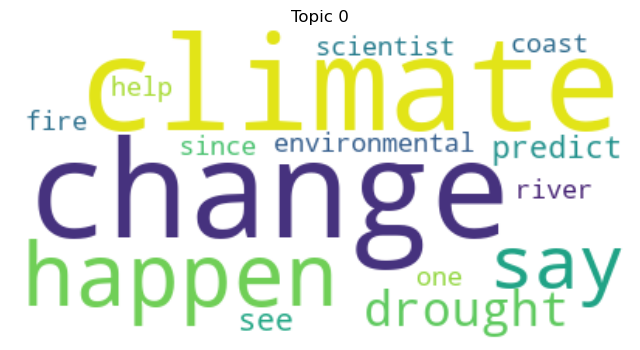

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(lda_model, topic_id, num_words=15):
    # Extract top words and their probabilities for the given topic
    topic_words = lda_model.show_topic(topic_id, topn=num_words)
    
    # Generate word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(topic_words))
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}')
    plt.show()

plot_word_cloud(lda_model, topic_id=0)


In [ ]:
# Term Frequency-Inverse Document Frequency (TF-IDF) Visualization

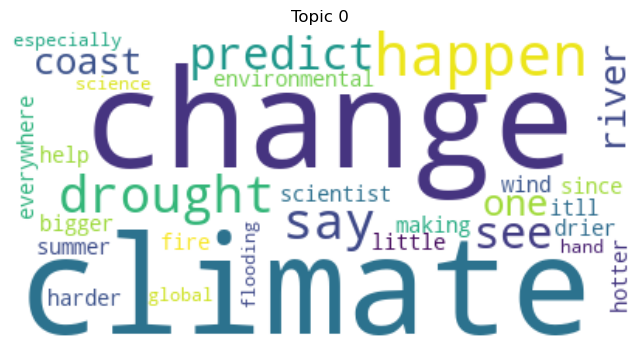

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud for a given topic
def plot_word_cloud(lda_model, topic_id, num_words=30):
    # Extract top words and their probabilities for the given topic
    topic_words = lda_model.show_topic(topic_id, topn=num_words)
    
    # Generate word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(topic_words))
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}')
    plt.show()

# Example usage
plot_word_cloud(lda_model, topic_id=0)


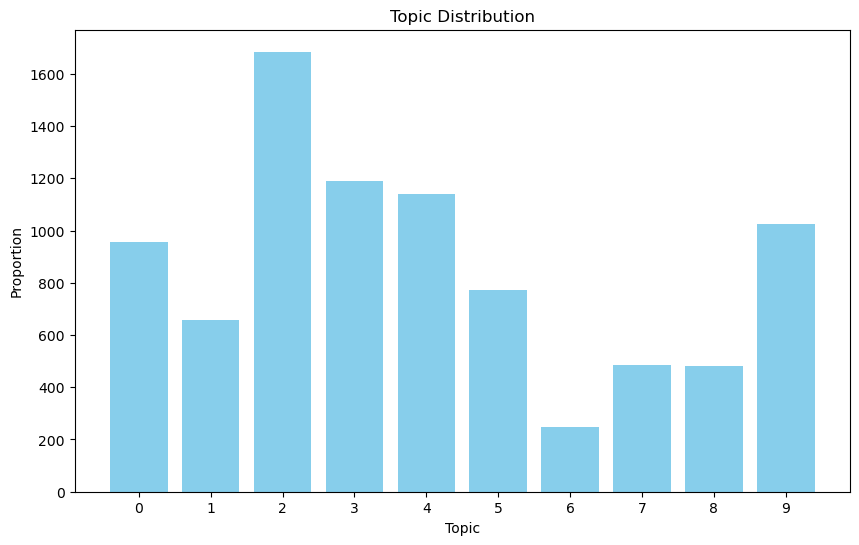

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_topic_distribution(lda_model, corpus):
    # Get topic distribution for each document
    topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]
    
    # Calculate topic proportions
    topic_proportions = np.zeros(lda_model.num_topics)
    for doc_topics in topic_distribution:
        for topic, proportion in doc_topics:
            topic_proportions[topic] += proportion
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(lda_model.num_topics), topic_proportions, color='skyblue')
    plt.title('Topic Distribution')
    plt.xlabel('Topic')
    plt.ylabel('Proportion')
    plt.xticks(range(lda_model.num_topics))
    plt.show()

# Example usage
plot_topic_distribution(lda_model, corpus)
